In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import astropy.units as u
import pandas as pd
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation

import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
from functools import partial
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
import astropy.units as u

import corner

In [2]:
period_est0, t0_est0, dur_est0 = 4.0552941, 2455342.96913, 0.1
M_star = 0.913, 0.047
R_star = 0.939, 0.022
# Around 90 earth mass
msini=90

In [3]:
rv_df = pd.concat([pd.read_csv('data/faedi.csv'), pd.read_csv('data/mancini.csv')]).reset_index(drop=True)

In [4]:
# I'm not correcting for HJD to BJD...
def clean_df(df):
    df['dmag'] = np.asarray([d.strip() for d in np.asarray(df.dmag)], float)
    df['e_dmag'] = np.asarray([d.strip() for d in np.asarray(df.e_dmag)], float)
    df['HJD'] = np.asarray([d.strip() for d in np.asarray(df.HJD)], float)
    df['flux'] = (10**(df.dmag/-2.5))
    df['flux_err'] = (np.log(10) * df.e_dmag/2.5) * df['flux']
    return df
wasp_df = clean_df(pd.read_csv('data/wasp-39.csv', comment='#', delimiter=';')[2:].reset_index(drop=True))
euler_df = clean_df(pd.read_csv('data/faedi_transit.csv', comment='#', delimiter=';')[2:].reset_index(drop=True))
FTN_df = clean_df(pd.read_csv('data/faedi_transit2.csv', comment='#', delimiter=';')[2:].reset_index(drop=True))
ricci_df = pd.read_csv('data/ricci_transit.csv')
ricci_df = ricci_df[(ricci_df.Filt == 'I')]# | (ricci_df.Filt == 'I')]
wfc3_df = pd.read_csv('data/WASP-39_transit_WFC3 (1).csv')
jwst_df = pd.read_csv('data/WASP-39_JWST.csv')
irac1_df = pd.read_csv('data/WASP-39_SpitzerIRAC1.csv')
irac2_df = pd.read_csv('data/WASP-39_SpitzerIRAC2.csv')
stis1_df = pd.read_csv("data/STIS-WASP39-G430L.csv").rename({'ferr':'flux_err', 'time':'BJD'}, axis=1)
stis1_df['texp'] = np.median(np.diff(stis1_df.BJD))

stis2_df = pd.read_csv("data/STIS-WASP39-G750L.csv").rename({'ferr':'flux_err', 'time':'BJD'}, axis=1)
stis2_df['texp'] = np.median(np.diff(stis1_df.BJD))

In [46]:
wasp_lc =lk.LightCurve(time=wasp_df.HJD, flux=wasp_df.flux, flux_err=wasp_df.flux_err)
wasp_lc = wasp_lc[np.unique(wasp_lc.time.value, return_inverse=True)[1]]
euler_lc = lk.LightCurve(time=euler_df.HJD, flux=euler_df.flux, flux_err=euler_df.flux_err)
FTN_lc = lk.LightCurve(time=FTN_df.HJD, flux=FTN_df.flux, flux_err=FTN_df.flux_err)
ricci_lc = lk.LightCurve(time=ricci_df.BJD, flux=ricci_df.Flux)
ricci_flc = ricci_lc.fold(4.0552941, 2455342.96913)
ricci_lc.flux_err = np.ones(len(ricci_lc)) * ricci_flc[np.abs(ricci_flc.time.value) > 0.06].flux.std()
wfc3_lc = lk.LightCurve(time=wfc3_df.BJD, flux=wfc3_df.flux, flux_err=wfc3_df.flux_err)
jwst_lc = lk.LightCurve(time=jwst_df.BJD, flux=jwst_df.flux, flux_err=jwst_df.flux_err)[300:]
irac1_lc = lk.LightCurve(time=irac1_df.BJD, flux=irac1_df.flux, flux_err=irac1_df.flux_err)
irac2_lc = lk.LightCurve(time=irac2_df.BJD, flux=irac2_df.flux, flux_err=irac2_df.flux_err)
tess_lc = lk.read('data/WASP-39b_TESS_Sector51_CorrectedLC.fits').normalize()
tess_lc.time.jd = tess_lc.time + 2457000
tess_lc.time.format = 'jd'
stis1_lc = lk.LightCurve(time=stis1_df.BJD, flux=stis1_df.flux, flux_err=stis1_df.flux_err/2)
stis2_lc = lk.LightCurve(time=stis2_df.BJD, flux=stis2_df.flux, flux_err=stis2_df.flux_err/2)

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

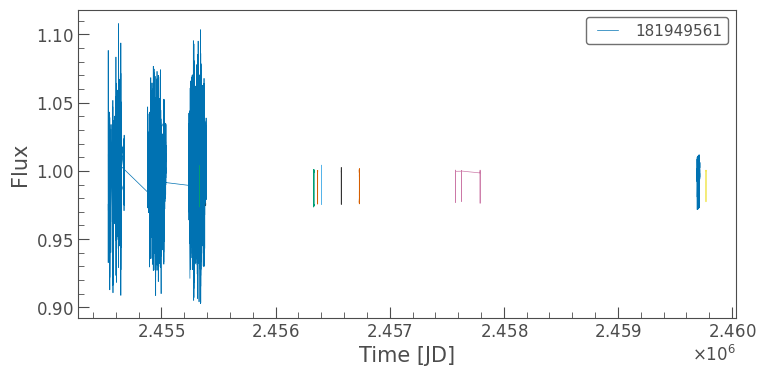

In [53]:
ax = euler_lc.plot()
wasp_lc.plot(ax=ax)
FTN_lc.plot(ax=ax)
ricci_lc.plot(ax=ax)
wfc3_lc.plot(ax=ax)
jwst_lc.plot(ax=ax)
irac1_lc.plot(ax=ax)
irac2_lc.plot(ax=ax)
tess_lc.plot(ax=ax)
stis1_lc.plot(ax=ax)
stis2_lc.plot(ax=ax)

<ErrorbarContainer object of 3 artists>

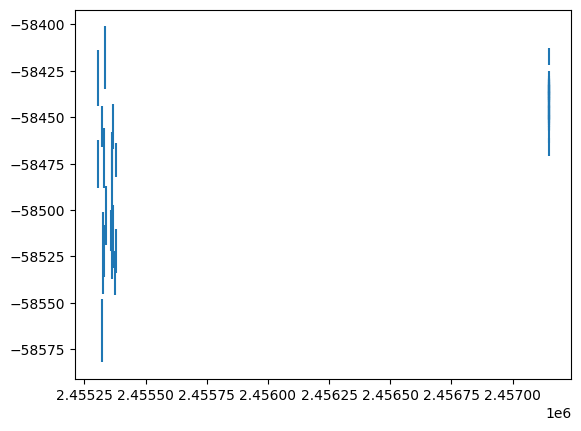

In [54]:
plt.errorbar(rv_df.BJD, rv_df.RV, rv_df.eRV, ls='')

# Tom notes

* Put in a tref to move the time to average 0
* Iterate, remove significant outliers
* Take out the half of a transit.

In [58]:
flc = wasp_lc.fold(period_est0, t0_est0)
wasp_transit_mask = np.in1d(wasp_lc.time.value, flc.time_original[np.abs(flc.phase.value) < dur_est0 * 2].value)

wasp_y = (wasp_lc[wasp_transit_mask].flux.value - 1)*1e3
wasp_yerr = (wasp_lc[wasp_transit_mask].flux_err.value)*1e3
wasp_x = wasp_lc[wasp_transit_mask].time.jd
a, b = np.unique(np.diff(np.sort(wasp_lc[wasp_transit_mask].time.value)), return_counts=True)
wasp_texp = a[np.argmax(b)]
wasp_sort = np.argsort(wasp_x)

flc = tess_lc.fold(period_est0, t0_est0)
tess_transit_mask = np.in1d(tess_lc.time.value, flc.time_original[np.abs(flc.phase.value) < dur_est0 * 1.5].value)
tess_y = (tess_lc[tess_transit_mask].flux.value - 1)*1e3
tess_yerr = (tess_lc[tess_transit_mask].flux_err.value)*1e3
tess_y /= np.median(tess_lc[~tess_transit_mask].flux.value)
tess_yerr /= np.median(tess_lc[~tess_transit_mask].flux.value)
tess_x = tess_lc[tess_transit_mask].time.jd


datasets = OrderedDict(
    [
        ("WASP", [wasp_x[wasp_sort], wasp_y[wasp_sort], wasp_yerr[wasp_sort], wasp_texp]),
        ("TESS", [tess_x, tess_y, tess_yerr, np.median(np.diff(tess_lc.time.jd.value))]),
        ("Ricci", [ricci_lc.time.jd, (ricci_lc.flux.value - 1)*1e3, (ricci_lc.flux_err.value)*1e3, np.median(np.diff(ricci_lc.time.jd))]),
        ("FTN", [FTN_lc.time.jd, (FTN_lc.flux.value - 1)*1e3, (FTN_lc.flux_err.value)*1e3, np.median(np.diff(FTN_lc.time.jd))]),
        ("Euler", [euler_lc.time.jd, (euler_lc.flux.value - 1)*1e3, (euler_lc.flux_err.value)*1e3, np.median(np.diff(euler_lc.time.jd))]),
        ("HST", [wfc3_lc.time.jd, (wfc3_lc.flux.value - 1)*1e3, (wfc3_lc.flux_err.value)*1e3, np.median(np.diff(wfc3_lc.time.jd))]),
        ("JWST", [jwst_lc.time.jd, (jwst_lc.flux.value - 1)*1e3, (jwst_lc.flux_err.value)*1e3, np.median(jwst_df.texp)]),
        ("IRAC1", [irac1_lc.time.jd, (irac1_lc.flux.value - 1)*1e3, (irac1_lc.flux_err.value)*1e3, np.median(irac1_df.texp)]),
        ("IRAC2", [irac2_lc.time.jd, (irac2_lc.flux.value - 1)*1e3, (irac2_lc.flux_err.value)*1e3, np.median(irac2_df.texp)]),
    ]
)

get_rv_from_df = lambda df, inst: [np.asarray(df['BJD'][df['Inst'] == inst]),
                                   np.asarray(df['RV'][df['Inst'] == inst] - np.median(df['RV'][df['Inst'] == inst])),
                                   np.asarray(df['eRV'][df['Inst'] == inst])
                                  ]
rv_datasets = OrderedDict([
        ("HARPS", get_rv_from_df(rv_df, "HARPSN")),
        ("CORALIE", get_rv_from_df(rv_df, "CORALIE")),
        ("SOPHIE", get_rv_from_df(rv_df, " SOPHIE")),
])

In [59]:
full_lc = lk.LightCurve(*np.vstack([np.vstack([x, y*1e-3 + 1, yerr*1e-3]).T for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items())]).T)
full_lc = full_lc[np.argsort(full_lc.time.value)]
bls = full_lc.normalize().to_periodogram('bls', minimum_period=period_est0*0.99, maximum_period=period_est0*1.01, duration=np.linspace(0.01, 0.1, 100), frequency_factor=10000)
period_est, t0_est, dur_est = bls.period_at_max_power.value, bls.transit_time_at_max_power.value, bls.duration_at_max_power.value

#depth_est = bls.compute_stats(period_est, dur_est, t0_est)['depth'][0].value
depth_est = 0.04
transit_times_est = bls.compute_stats(period_est, dur_est, t0_est)['transit_times'].value
transit_inds_est = np.arange(len(transit_times_est), dtype=int)
transit_times_est, transit_inds_est = np.asarray([(t, ti) for t, ti in zip(transit_times_est, transit_inds_est) if np.any((np.abs(full_lc.time.value - t) * 24) < 3)]).T
transit_times_est = list(transit_times_est)
transit_inds_est = list(transit_inds_est.astype(int))

/Users/ch/.pyenv/versions/3.8.7/lib/python3.8/site-packages/lightkurve/lightcurve.py:277: LightkurveDeprecationWarning: passing flux as a positional argument is deprecated, please use ``flux=...`` instead.
  warnings.warn(


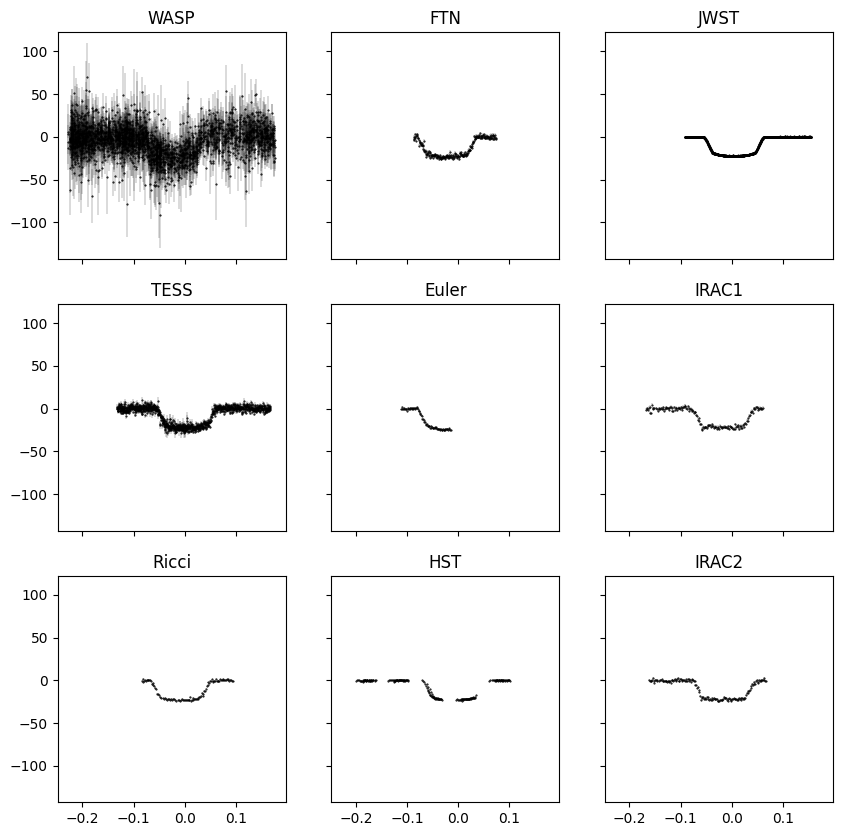

In [62]:
fig, ax = plt.subplots(3, np.ceil(len(datasets)/3).astype(int), sharex=True, sharey=True, figsize=(10, 10))
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    idx = n % 3
    jdx = (n - idx)//3
    ph = (x - t0_est + 0.5 * period_est) % period_est - 0.5 * period_est
    ax[idx, jdx].errorbar(ph, y, yerr, ls='', label=name, lw=0.2, c='k', marker='.', ms=1)
    ax[idx, jdx].set(title=name)

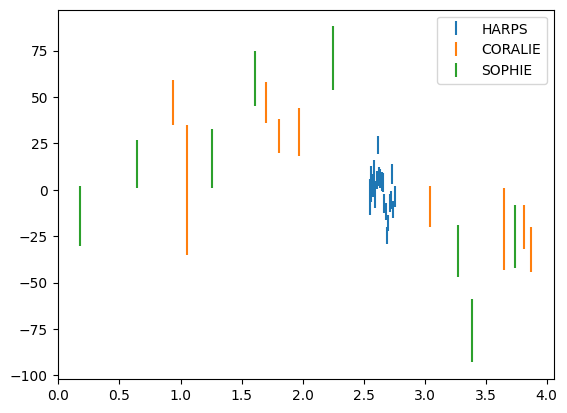

In [63]:
plt.figure()
for n, (name, (x, y, yerr)) in enumerate(rv_datasets.items()):
    plt.errorbar(x % period_est, y, yerr, ls='', label=name)
plt.legend()

In [590]:
with pm.Model() as model:
    
    # Star parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
    m_star = BoundedNormal(
        "m_star", mu=M_star[0], sd=M_star[1]
    )
    r_star = BoundedNormal(
        "r_star", mu=R_star[0], sd=R_star[1]
    )
    b = pm.Uniform("b", lower=0, upper=1, shape=1)
    ld_arg = 1 - tt.sqrt(1 - b**2)
    
    BoundedNormal = pm.Bound(pm.Normal, lower=-0.05, upper=0.05)
    transit_times = [BoundedNormal("tts",
            mu=0,
            sd=0.02,
            shape=len(transit_times_est),
        ) + transit_times_est]
        
    orbit = xo.orbits.TTVOrbit(
            r_star=r_star,
            m_star=m_star,
            b=b,
            transit_times=transit_times,
            transit_inds=[transit_inds_est]
        )
    
    parameters = dict()
    lc_models = dict()
    for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
        # We define the per-instrument parameters in a submodel so that we
        # don't have to prefix the names manually
        with pm.Model(name=name, model=model):
            # The flux zero point
            mean = pm.Normal("mean", mu=0.0, sigma=10.0)
            u_star = xo.QuadLimbDark("u")
            star = xo.LimbDarkLightCurve(u_star)
            
            # The radius ratio
            log_approx_depth = pm.Normal(
                "log_approx_depth", mu=np.log(depth_est), sigma=10
            )
            ld = 1 - u_star[0] * ld_arg - u_star[1] * ld_arg**2
            ror = pm.Deterministic(
                "ror", tt.exp(0.5 * log_approx_depth) / tt.sqrt(ld)
            )
            r_pl = pm.Deterministic("r_pl", ror * r_star)
            
            # Noise parameters
            med_yerr = np.median(yerr)
            std = np.std(y)
            # This doesn't seem right...
            sigma = pm.InverseGamma(
                "sigma",
                testval=med_yerr,
                **pmx.estimate_inverse_gamma_parameters(
                    lower=med_yerr, upper=0.5 * std
                ),
            )
            # Keep track of the parameters for optimization
            parameters[name] = [mean, u_star, ror]
            parameters[f"{name}_noise"] = [sigma]
            
         # The light curve model
        def lc_model(mean, star, ror, texp, t):
            return mean + (1e3 * tt.sum(
                star.get_light_curve(orbit=orbit, r=ror, t=t, texp=texp),
                axis=-1,
            ))

        light_curve = lc_model(mean, star, ror, texp, x)
        lc_models[name] = light_curve
        pm.Normal(f"{name}_obs", observed=y, sd=(yerr**2 + sigma**2)**0.5, mu=light_curve)
    
    pm.Deterministic("t0", orbit.t0)
    pm.Deterministic("period", orbit.period)
    map_soln = model.test_point
    map_soln = pmx.optimize(map_soln, [*transit_times, m_star, r_star, b])
    for name in datasets:
        map_soln = pmx.optimize(map_soln, parameters[name])
    map_soln = pmx.optimize(map_soln, [*[parameters[f"{name}_noise"][0] for name in datasets], *transit_times, m_star, r_star, b])
    map_soln = pmx.optimize(map_soln)

optimizing logp for variables: [b, r_star, m_star, tts]


message: Desired error not necessarily achieved due to precision loss.
logp: -218405.16292065126 -> -21168.917410227114
optimizing logp for variables: [WASP_log_approx_depth, WASP_u, b, WASP_mean]


message: Optimization terminated successfully.
logp: -21168.917410227114 -> -21167.48486594205
optimizing logp for variables: [TESS_log_approx_depth, TESS_u, b, TESS_mean]


message: Optimization terminated successfully.
logp: -21167.48486594205 -> -21152.223661695098
optimizing logp for variables: [Ricci_log_approx_depth, Ricci_u, b, Ricci_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -21152.223661695098 -> -21145.164330295236
optimizing logp for variables: [FTN_log_approx_depth, FTN_u, b, FTN_mean]


message: Optimization terminated successfully.
logp: -21145.164330295236 -> -21140.298955139908
optimizing logp for variables: [Euler_log_approx_depth, Euler_u, b, Euler_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -21140.298955139908 -> -21122.486999664583
optimizing logp for variables: [HST_log_approx_depth, HST_u, b, HST_mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -21122.486999664583 -> -17820.81003056249
optimizing logp for variables: [JWST_log_approx_depth, JWST_u, b, JWST_mean]


message: Optimization terminated successfully.
logp: -17820.81003056249 -> -15084.096017973641
optimizing logp for variables: [IRAC1_log_approx_depth, IRAC1_u, b, IRAC1_mean]


message: Optimization terminated successfully.
logp: -15084.096017973641 -> -15062.38628248713
optimizing logp for variables: [IRAC2_log_approx_depth, IRAC2_u, b, IRAC2_mean]


message: Optimization terminated successfully.
logp: -15062.38628248713 -> -14997.748529884228
optimizing logp for variables: [b, r_star, m_star, tts, IRAC2_sigma, IRAC1_sigma, JWST_sigma, HST_sigma, Euler_sigma, FTN_sigma, Ricci_sigma, TESS_sigma, WASP_sigma]


message: Desired error not necessarily achieved due to precision loss.
logp: -14997.748529884228 -> -13814.199333601222
optimizing logp for variables: [IRAC2_sigma, IRAC2_log_approx_depth, IRAC2_u, IRAC2_mean, IRAC1_sigma, IRAC1_log_approx_depth, IRAC1_u, IRAC1_mean, JWST_sigma, JWST_log_approx_depth, JWST_u, JWST_mean, HST_sigma, HST_log_approx_depth, HST_u, HST_mean, Euler_sigma, Euler_log_approx_depth, Euler_u, Euler_mean, FTN_sigma, FTN_log_approx_depth, FTN_u, FTN_mean, Ricci_sigma, Ricci_log_approx_depth, Ricci_u, Ricci_mean, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, WASP_sigma, WASP_log_approx_depth, WASP_u, WASP_mean, tts, b, r_star, m_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -13814.199333601222 -> -11821.093531831406


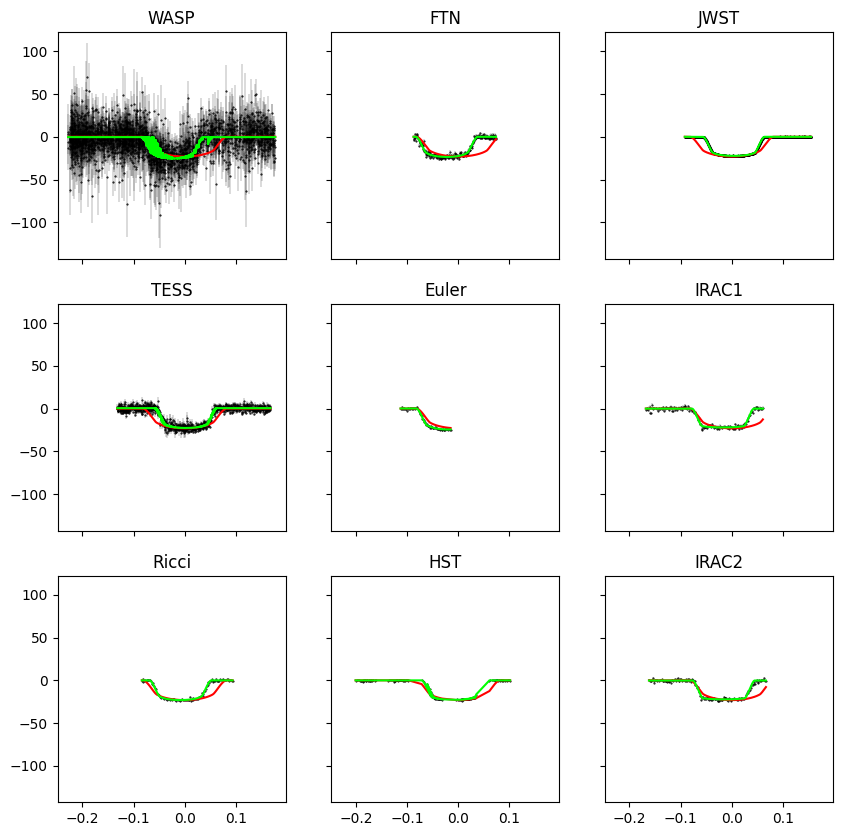

In [591]:
l0 = pmx.eval_in_model(lc_models, model=model, point=model.test_point)
l = pmx.eval_in_model(lc_models, model=model, point=map_soln)

fig, ax = plt.subplots(3, np.ceil(len(datasets)/3).astype(int), sharex=True, sharey=True, figsize=(10, 10))
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    idx = n % 3
    jdx = (n - idx)//3
    ph = (x - t0_est + 0.5 * period_est) % period_est - 0.5 * period_est
    s = np.argsort(ph)
    ax[idx, jdx].errorbar(ph, y, yerr, ls='', label=name, lw=0.2, c='k', marker='.', ms=1, zorder=-1)
    ax[idx, jdx].plot(ph[s], l0[name][s], c='r', zorder=10)
    ax[idx, jdx].plot(ph[s], l[name][s], c='lime', zorder=10)
    ax[idx, jdx].set(title=name)

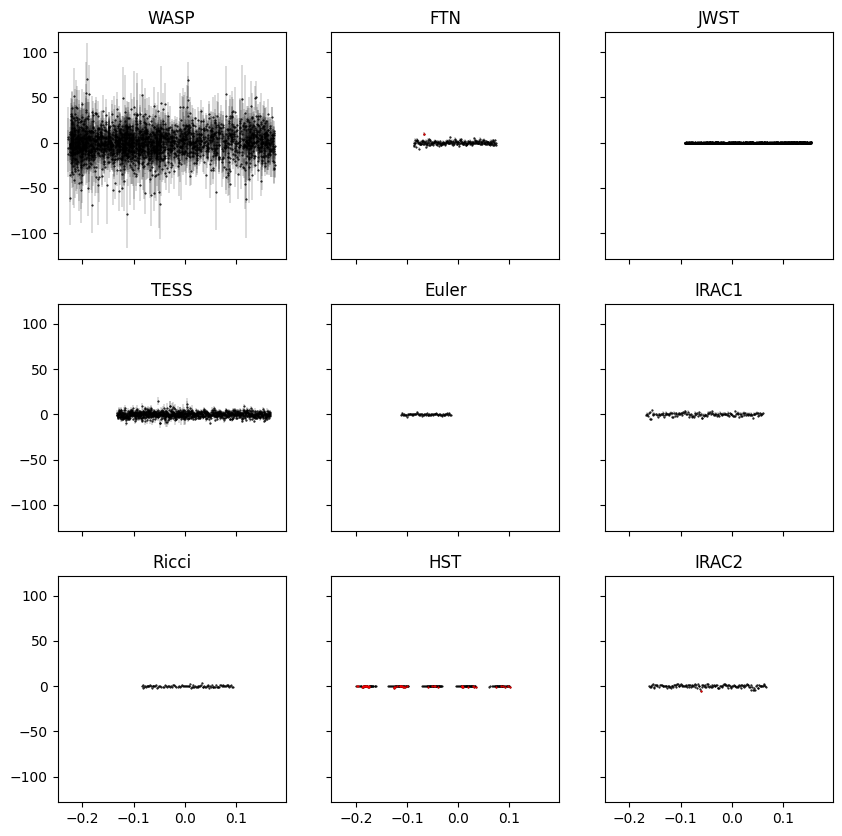

In [592]:
l0 = pmx.eval_in_model(lc_models, model=model, point=model.test_point)
l = pmx.eval_in_model(lc_models, model=model, point=map_soln)

fig, ax = plt.subplots(3, np.ceil(len(datasets)/3).astype(int), sharex=True, sharey=True, figsize=(10, 10))
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    idx = n % 3
    jdx = (n - idx)//3
    ph = (x - t0_est + 0.5 * period_est) % period_est - 0.5 * period_est
    s = np.argsort(ph)
    ax[idx, jdx].errorbar(ph, y - l[name], yerr, ls='', label=name, lw=0.2, c='k', marker='.', ms=1, zorder=-1)
    k = np.abs(y - l[name])/yerr > 4
    ax[idx, jdx].errorbar(ph[k], (y - l[name])[k], yerr[k], ls='', label=name, lw=0.2, c='r', marker='.', ms=1, zorder=-1)

    ax[idx, jdx].set(title=name)

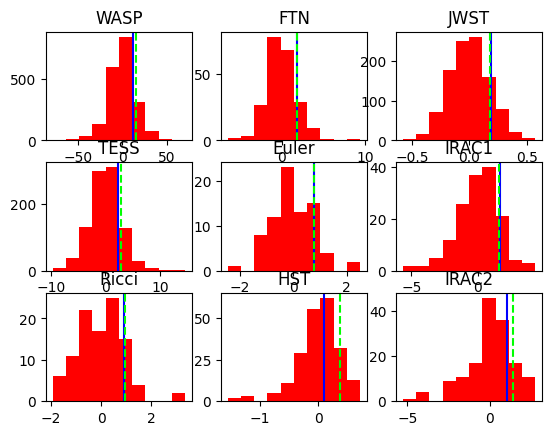

In [595]:
l0 = pmx.eval_in_model(lc_models, model=model, point=model.test_point)
l = pmx.eval_in_model(lc_models, model=model, point=map_soln)

fig, ax = plt.subplots(3, np.ceil(len(datasets)/3).astype(int))
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    idx = n % 3
    jdx = (n - idx)//3
    res = y - l[name]
    ax[idx, jdx].hist(res, ls='', label=name, color='r')
    ax[idx, jdx].axvline(np.median(yerr), color='b')
    ax[idx, jdx].axvline(np.std(res), color='lime', ls='--')
    ax[idx, jdx].set(title=name)

In [596]:
map_soln['']

{'m_star_interval__': array(-0.79090966),
 'r_star_interval__': array(-0.80795029),
 'b_interval__': array([-0.17047226]),
 'tts_interval__': array([-6.60147543e-01,  4.20536238e-06,  3.27578714e-05, -8.91060360e-06,
        -1.46219316e-05, -9.62913200e-01, -1.06206260e+00, -1.03675792e+00,
        -1.13012132e+00, -8.89171111e-01, -1.79437109e-05, -1.03754424e+00,
        -7.82497216e-01, -1.24385975e-01, -8.37263786e-01,  5.42658738e-06,
         4.90641235e-06, -4.73497604e-01, -1.99943587e-01, -9.64168804e-01,
         3.42941522e-06, -1.89731931e-01, -9.92095704e-01,  3.08065523e-06,
        -9.95432087e-01, -6.58158185e-02, -9.35065993e-01, -9.06948082e-01,
        -7.17175316e-01, -6.44977203e-01, -3.34979582e-01, -4.33697060e-01,
        -2.44794104e-01, -3.98102152e-01,  6.39774251e-03,  4.77585167e-02,
         1.43892609e-01,  1.33993373e-01,  1.11482864e-01,  1.59163399e-01]),
 'WASP_mean': array(-0.37570409),
 'WASP_u_quadlimbdark__': array([-0.5158736 ,  0.10747772]),
 '

In [571]:
np.random.seed(230948)
with model:
    trace = pmx.sample(
        tune=500,
        draws=500,
        start=map_soln,
        cores=4,
        chains=4,
        return_inferencedata=True,
    )

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [IRAC2_sigma, IRAC2_log_approx_depth, IRAC2_u, IRAC2_mean, IRAC1_sigma, IRAC1_log_approx_depth, IRAC1_u, IRAC1_mean, JWST_sigma, JWST_log_approx_depth, JWST_u, JWST_mean, HST_sigma, HST_log_approx_depth, HST_u, HST_mean, FTN_sigma, FTN_log_approx_depth, FTN_u, FTN_mean, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, tts, b, r_star, m_star]
INFO:pymc3:NUTS: [IRAC2_sigma, IRAC2_log_approx_depth, IRAC2_u, IRAC2_mean, IRAC1_sigma, IRAC1_log_approx_depth, IRAC1_u, IRAC1_mean, JWST_sigma, JWST_log_approx_depth, JWST_u, JWST_mean, HST_sigma, HST_log_approx_depth, HST_u, HST_mean, FTN_sigma, FTN_log_approx_depth, FTN_u, FTN_mean, TESS_sigma, TESS_log_approx_depth, TESS_u, TESS_mean, tts, b, r_star, m_star]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 223 seconds.
INFO:pymc3:Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 223 seconds.


In [572]:
map_soln

{'m_star_interval__': array(-0.7912465),
 'r_star_interval__': array(-0.8077551),
 'b_interval__': array([-0.16762737]),
 'tts_interval__': array([-0.40765496, -0.32765834, -0.28344723, -0.20840563, -0.0306724 ,
        -0.20045145, -0.03267123,  0.00780425,  0.10328607,  0.0928559 ,
         0.06942276,  0.10999249]),
 'TESS_mean': array(0.47381693),
 'TESS_u_quadlimbdark__': array([-1.02066562, -0.66782381]),
 'TESS_log_approx_depth': array(-4.07200304),
 'TESS_sigma_log__': array(0.4283335),
 'FTN_mean': array(-0.04330724),
 'FTN_u_quadlimbdark__': array([-0.26157097, -1.01909718]),
 'FTN_log_approx_depth': array(-4.08602425),
 'FTN_sigma_log__': array(0.30256878),
 'HST_mean': array(-0.0717867),
 'HST_u_quadlimbdark__': array([-2.08831214, -0.14118712]),
 'HST_log_approx_depth': array(-4.04750923),
 'HST_sigma_log__': array(-1.05418785),
 'JWST_mean': array(-0.02230796),
 'JWST_u_quadlimbdark__': array([-1.05475012, -1.12384082]),
 'JWST_log_approx_depth': array(-4.09138954),
 'JWS

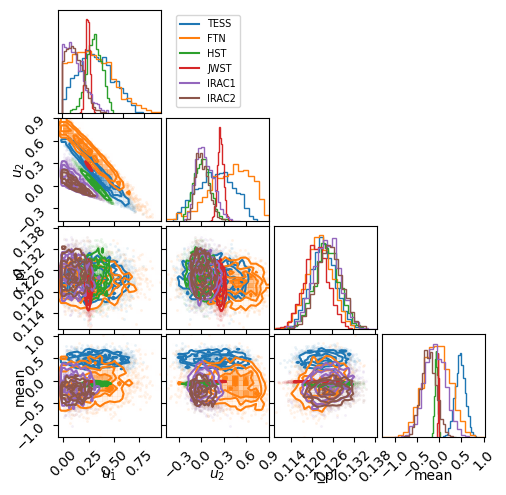

In [573]:
fig = plt.figure(figsize=(5, 5))
for n, (name, (x, y, yerr, texp)) in enumerate(datasets.items()):
    corner.corner(
        trace,
        var_names=[f"{name}_u", f"{name}_r_pl", f'{name}_mean'], color=f'C{n}', fig=fig, labels=["$u_1$", "$u_2$", "r_pl", 'mean']);
    fig.axes[0].axvline(-1.0, color=f"C{n}", label=name)
_ = fig.axes[0].legend(
    fontsize=7, loc="center left", bbox_to_anchor=(1.1, 0.5)
)

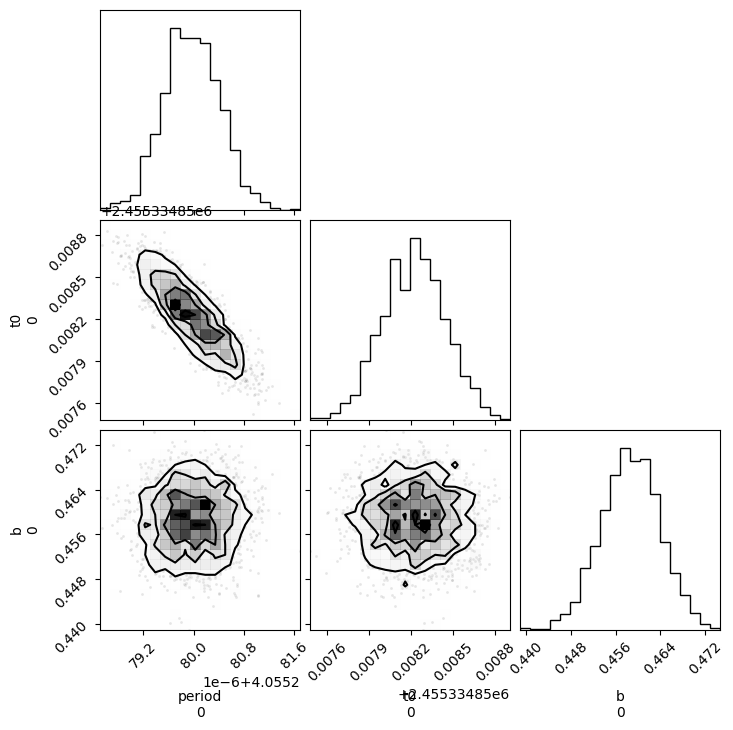

In [574]:
corner.corner(trace, var_names=['period', 't0', 'b']);

In [577]:
trace_period = np.vstack(trace.posterior['period']).mean(axis=0)[0]
trace_t0 = np.vstack(trace.posterior['t0']).mean(axis=0)[0]

Text(0.5, 0, 'Transit Time [days]')

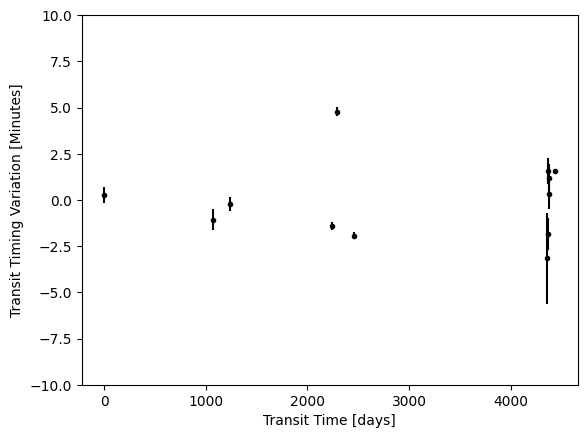

In [580]:
tt1 = np.asarray(transit_inds_est) * trace_period + trace_t0
x, y, ye = tt1, np.vstack(trace['posterior']['tts'] + transit_times_est).mean(axis=0) - tt1, np.vstack(trace['posterior']['tts'] + transit_times_est).std(axis=0)
plt.errorbar((x - x[0]), y*24*60, ye*24*60, ls='', marker='.', c='k')
plt.ylim(-10, 10)
plt.ylabel('Transit Timing Variation [Minutes]')
plt.xlabel("Transit Time [days]")